In [21]:
import datetime
import os
import time
import sys
import importlib
import glob

import numpy as np
from numpy import pi
import numpy.random as nprnd
import numpy.linalg as npla
import xarray as xr

import scipy as scp
import scipy.integrate as scpint
import scipy.stats as scpst
import scipy.io as scpio

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [22]:
def l63rhs(xin, tin, pars):
  return l63rhs_ode(tin, xin, pars)

def l63rhs_ode(tin, xin, pars):
  frhs = xin*0.0
  beta, sigma, rho = pars
  x, y, z = xin
  frhs[0] = sigma * (y - x)
  frhs[1] = x * (rho - z) - y
  frhs[2] = x * y - beta * z
  return frhs

def l63rhs_df(xin,tin,pars):
  df = np.zeros((3,3))
  beta, sigma, rho = pars
  x, y, z = xin
  df[0,0] = -sigma; df[0,1] = sigma;
  df[1,0] = rho - z; df[1,1] = -1.0; df[1,2] = -x;
  df[2,0] = y; df[2,1] = x; df[2,2] = -beta;
  return df
  
def l63rhslin(zin, tin, pars):
  '''
  Here zin must be 12 dimensionsal: xin, followed by rows of mlin
  '''
  beta, sigma, rho = pars
  ndim = 3
  xin = zin[:ndim]
  mlin = np.reshape(zin[ndim:],(ndim,ndim),'F')

  df = l63rhs_df(xin, tin, pars)
  xin = l63rhs(xin, tin, pars)
  mlin = np.dot(df, mlin)
  
  frhs = np.concatenate((xin, np.reshape(mlin,ndim**2,'F')))
  return frhs

def l63rhslin_ode(tin, xin, pars):
  return l63rhslin(xin, tin, pars)

def l63rhslinvec(zin, tin, pars):
  '''
  Here zin must be 6 dimensionsal: xin, followed by zlin
  '''
  beta, sigma, rho = pars
  ndim = 3
  xin = zin[:ndim]
  zlin = zin[ndim:]

  df = l63rhs_df(xin, tin, pars)
  xin = l63rhs(xin, tin, pars)
  zlin = np.dot(df, zlin)
  
  frhs = np.concatenate((xin, zlin))
  return frhs

def l63rhslinvec_ode(tin, xin, pars):
  return l63rhslinvec(xin, tin, pars)

def run_solver(pars, ndim, max_t):
  np.random.seed(657183)
  xrand = np.random.rand(ndim)
  ttrans = np.linspace(0,100,1000)
  xtrans = scp.integrate.odeint(l63rhs, xrand, ttrans, (pars,))

  t = np.linspace(0,max_t,100000)
  xattr = xtrans[-1,:]

  xinit1 = xattr
  xtraj1 = scp.integrate.odeint(l63rhs, xinit1, t, (pars,))

  # xinit2 = np.random.rand(ndim) # xattr + np.random.rand(ndim)*1.0e-8
  xinit2 = xinit1 + np.random.rand(ndim)*1.0e-8
  xtraj2 = scp.integrate.odeint(l63rhs, xinit2, t, (pars,))

  trajdiff = np.array([np.linalg.norm(v) for v in xtraj1-xtraj2])
  return xtraj1, xtraj2, trajdiff, t

# lyapunov exponenet is defined as lambda; exp(nlambda)= delta_n/delta_0 when n tends to large numbers
# delta_0 is the distance between two close points 
# delta_n = difference between x1 and x0 at some large time n
# slope obtained after fitting a line to log(trajdiff) gives us the lyapunov exponenet.

def compute_lyapunov_given_trajdiff(trajdiff):
    trajdiff_ln= [np.log(i) for i in trajdiff]
    trajdiff_diff= trajdiff_ln- np.mean(trajdiff_ln); t_diff= t- np.mean(t)
    lyapunov= (np.sum(trajdiff_diff*t_diff)/ np.sum(t_diff*t_diff)) #regression
    return lyapunov,trajdiff_ln

# Rho=20

In [23]:
beta = 8.0/3;  sigma = 10.0;  rho = 20.0
pars = (beta,sigma,rho)
ndim = 3
xtraj1, xtraj2, trajdiff, t= run_solver(pars, ndim, max_t=100)

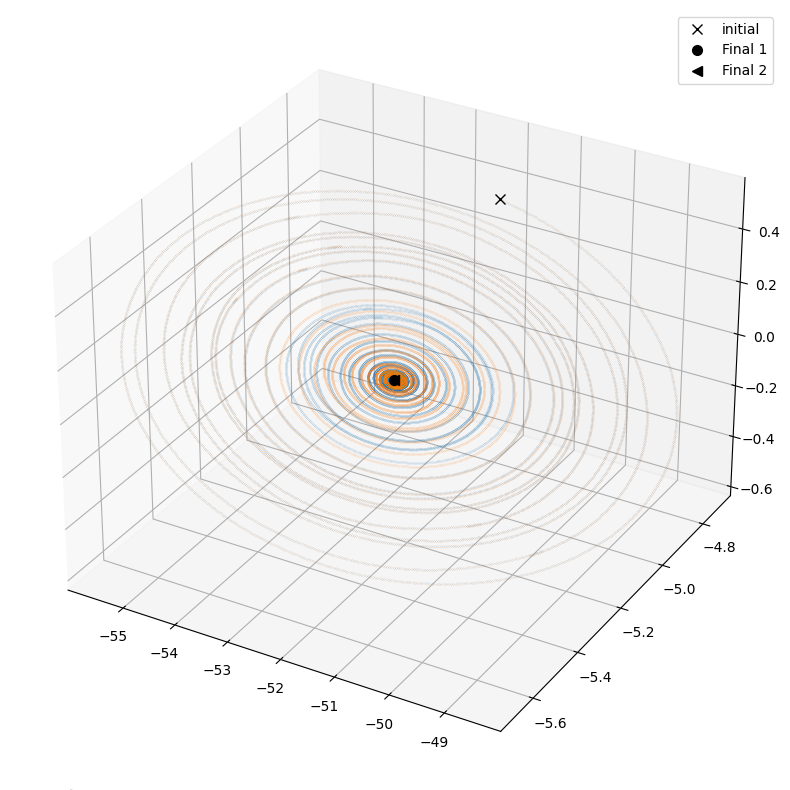

In [24]:
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.plot(xtraj1[:,0], xtraj1[:,1], xtraj1[:,2], '.', ms=0.1)
ax.plot(xtraj2[:,0], xtraj2[:,1], xtraj2[:,2], '.', ms=0.1)

ax.plot(xtraj1[0,0], xtraj1[0,1], xtraj1[0,2], 'xk', ms=7, label="initial")

ax.plot(xtraj1[-1,0], xtraj1[-1,1], xtraj1[-1,2], 'ok', ms=7, label="Final 1")
ax.plot(xtraj2[-1,0], xtraj2[-1,1], xtraj2[-1,2], '<k', ms=7, label="Final 2")

plt.legend()
plt.tight_layout()

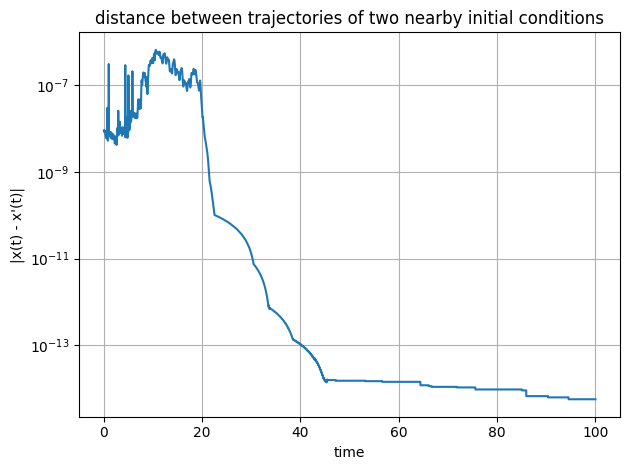

In [25]:
plt.semilogy(t, trajdiff)
plt.xlabel('time')
plt.ylabel("|x(t) - x'(t)|")
plt.title("distance between trajectories of two nearby initial conditions")
plt.grid()
plt.tight_layout()

In [26]:
lyapunov, trajdiff_ln= compute_lyapunov_given_trajdiff(trajdiff)
print(lyapunov)   

-0.19014833144637014


# Rho= 350

In [27]:
beta = 8.0/3;  sigma = 10.0;  rho = 350.0
pars = (beta,sigma,rho)
ndim = 3
xtraj1, xtraj2, trajdiff, t= run_solver(pars, ndim, max_t=50)

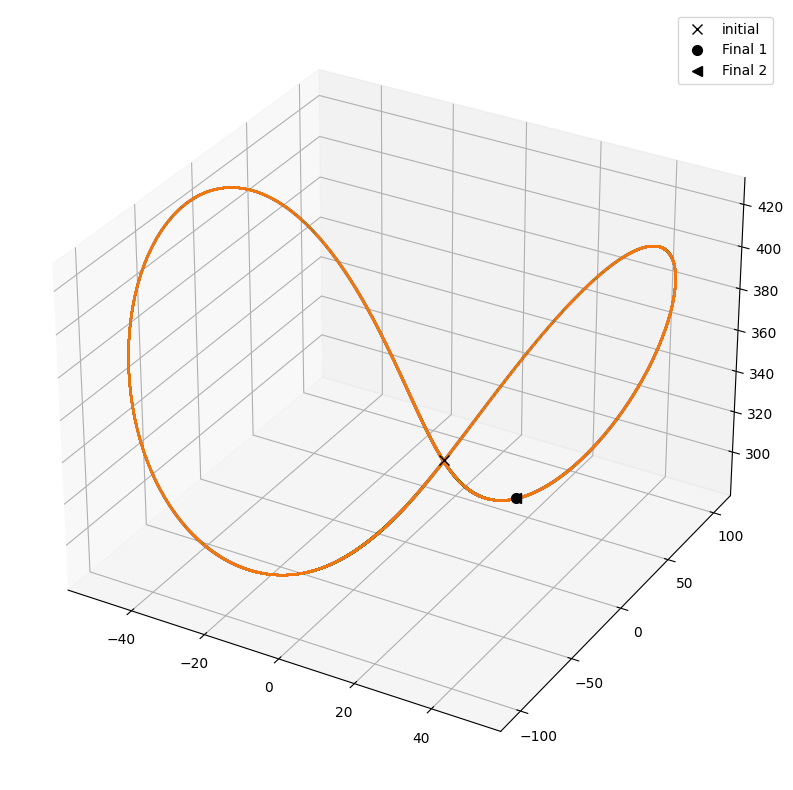

In [28]:
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.plot(xtraj1[:,0], xtraj1[:,1], xtraj1[:,2], '.', ms=0.1)
ax.plot(xtraj2[:,0], xtraj2[:,1], xtraj2[:,2], '.', ms=0.1)

ax.plot(xtraj1[0,0], xtraj1[0,1], xtraj1[0,2], 'xk', ms=7, label="initial")

ax.plot(xtraj1[-1,0], xtraj1[-1,1], xtraj1[-1,2], 'ok', ms=7, label="Final 1")
ax.plot(xtraj2[-1,0], xtraj2[-1,1], xtraj2[-1,2], '<k', ms=7, label="Final 2")

plt.legend()
plt.tight_layout()

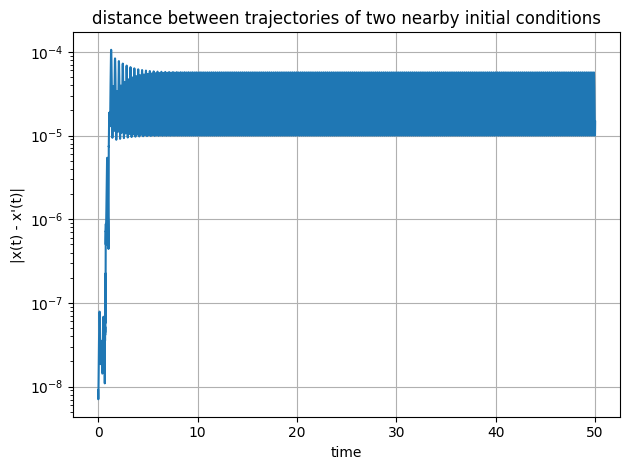

In [29]:
plt.semilogy(t, trajdiff)
plt.xlabel('time')
plt.ylabel("|x(t) - x'(t)|")
plt.title("distance between trajectories of two nearby initial conditions")
plt.grid()
plt.tight_layout()

In [30]:
lyapunov, trajdiff_ln= compute_lyapunov_given_trajdiff(trajdiff)
print(lyapunov) 

0.014125994660284608
